In [126]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import imageio.v2 as imageio

In [127]:
# Load Classnames
path='/Users/cap/Dropbox/Cuisines'
img_path='/Users/cap/Dropbox/Cuisines/images'
classes = []
num_foods = 0
img_count = 0

for file in os.listdir(img_path):
    if (file.startswith('.')): continue #ignore hidden files
    classes.append(file)

num_foods = len(classes)
    
'''
# More legible food names
for i in range (0, num_foods-1):
    if (dir_list[i].startswith('.')): continue #ignore hidden files
    class_name = ''
    for char in dir_list[i]:
        if (char == '-'):
            class_name += " "
        else:
            class_name += char
    classes.append(class_name.title())
'''

food_names = sorted(classes)
food_dict = {
    1:'bangbang-chicken',
    2:'dan-dan-noodles',
    3: 'sichuan-hot-pot',
    4: 'twice-cooked-pork',
    5: 'wontons-in-chili-oil',
}
print(food_names, num_foods)

['bangbang-chicken', 'dan-dan-noodles', 'sichuan-hot-pot', 'twice-cooked-pork', 'wontons-in-chili-oil'] 5


In [128]:
# Load Images using imageio and os package

base_dir = '/Users/cap/Dropbox/Cuisines/images'

# list all images in each file
# in each file split dataset into train and test
# add train and test file name to dictionary

images_dict = {
}

for i in range(0, num_foods):
    name = food_names[i]
    images_dict[name] = []
    for img in os.listdir(os.path.join(img_path,name)):
        if (img.startswith('.')): continue #ignore hidden files
        images_dict[name].append(img)


dataset = {}

for class_id in images_dict:
    images_list = images_dict[class_id]
    train_stop = int(len(images_list) * 0.8)
    train_files = images_list[:train_stop]
    validation_files = images_list[train_stop:]
    train_images = [imageio.imread(os.path.join(img_path,os.path.join(class_id,f))) for f in train_files]
    validation_images = [imageio.imread(os.path.join(img_path, os.path.join(class_id,f))) for f in validation_files]
    dataset[class_id] = {
        'train': train_images,
        'val': validation_images,
        'train_f': train_files,
        'val_f': validation_files
    }

for class_id in dataset:
    img_count += len(dataset[class_id]['train_f']) + len(dataset[class_id]['val_f'])
    print('train: {}'.format(class_id), dataset[class_id]['train_f'], sep='\n')
    print('test: {}'.format(class_id), dataset[class_id]['val_f'], sep='\n')
    print('\n')
    

train: bangbang-chicken
['5b5f992719233e2a59417d35b8464df6.jpg', 'bang-bang-chicken-8.jpg', '05542cfd530dfe596a122a65f26837b9.jpg', 'Bang-Bang-Chicken-819x1024.jpg', '75c53e2b6db04fe233c96c138c374a05.jpg', 'download-9.jpg', 'download-8.jpg', 'szechuan-chicken-5.jpg', '74bd4c3204c9b72f1f000c641574ff0c.jpg', 'download.jpg', 'd6fbd5ed99fa1d06a4ff81201dc98547.jpg', '68afb09c067356df819416a2a454c3e6.jpg', 'images-7.jpg', 'OIP-7.jpg', 'OIP-6.jpg', 'images-6.jpg', 'Sichuan-Bang-Bang-Chicken-7.jpg', 'images-4.jpg', 'OIP-4.jpg', '4728c1f876fdbcb33b08b571151ccd64.jpg', 'e0803deac5359f795620c01b3bfa86bf.jpg', 'OIP-5.jpg', 'images-5.jpg', 'OIP-1.jpg', 'images-1.jpg', '6ff5bb7d1f1e2b5c0cbaeae49b12b497.jpg', 'OIP-2.jpg', 'images-2.jpg', 'a5206908799e6b861c90620431180a71.jpg', 'images-3.jpg', 'OIP-3.jpg', 'd316dcfe3f35c104317dc78b048ba1fc.jpg', '8f044acd425550f197b8b96259e1253f.jpg', 'c7b20a024c6009350c357423eb81b660.jpg', '452cc92801c25531976a93548551a8ad.jpg', 'images-10.jpg', 'images-11.jpg', '4df

In [129]:
from tqdm import tqdm
import random
import skimage.transform as transforms
from sklearn.decomposition import PCA

class FeatureExtractor:
    def __init__(self, in_features=20, out_classes=num_foods):
        self.pca = PCA(n_components = in_features)
        self.out_classes = out_classes
        self.training = True
    
    def extract_features(self, x):
        self.pca.fit((x[:,:,0] + x[:,:,1] + x[:,:,2])/3)
        p = self.pca.singular_values_
        return p
        
        
class SimpleDataloader:
    def __init__(self, images_dict, shuffle=False, width=224, height=224):
        self.feature_extractor = FeatureExtractor()
        self.images_dict = images_dict
        self.mode = 'train'
        self.train_list = []
        self.val_list = []
        self.shuffle = shuffle
        self.width = width
        self.height = height
        self.train_images = []
        self.val_images = []
        self.train_features = []
        self.val_features = []
        pbar = tqdm(total=img_count)
        for class_id in self.images_dict:
            for i in range(len(self.images_dict[class_id]['train'])):
                self.train_list.append((class_id, i))
                image = self.transform(self.images_dict[class_id]['train'][i])
                features = self.feature_extractor.extract_features(image)
                self.train_images.append(image)
                self.train_features.append(features)
                pbar.update(1)
            for i in range(len(self.images_dict[class_id]['val'])):
                self.val_list.append((class_id,i))
                image = self.transform(self.images_dict[class_id]['val'][i])
                features = self.feature_extractor.extract_features(image)
                self.val_images.append(image)
                self.val_features.append(features)
                pbar.update(1)
            
        self.set_mode('train', True)
        
    def set_shuffle(self, shuffle):
        self.shuffle = shuffle
        
        
    def reset_shuffle(self):
        self.indexes = list(range(len(self.data_list)))
        if self.shuffle:
            random.shuffle(self.indexes)
    
    def set_mode(self, mode, shuffle):
        self.set_shuffle(shuffle)
        assert mode == 'train' or mode == 'val', 'only supports training or validation'
        self.mode = mode
        if mode == 'train':
            self.data_list = self.train_list
            self.data = self.train_images
            self.features = self.train_features
        else:
            self.data_list = self.val_list
            self.data = self.val_images
            self.features = self.val_features
        self.reset_shuffle()
        
    def transform(self, image):
        height, width, ch = image.shape
        if width < height:
            new_width = self.width
            scale = self.width / width
            new_height = int(height * scale)
        else:
            new_height = self.height
            scale = self.height / height
            new_width = int(width * scale)
        image_tf = transforms.resize(image, (new_height, new_width))
        
        # center crop
        w_start = 0
        w_stop = self.width
        h_start = 0
        h_stop = self.height
        if new_width > self.width:
            start = (new_width - self.width) // 2
            w_start = start
            w_stop = start + self.width
        if new_height > self.height:
            start = (new_height - self.height) // 2
            h_start = start
            h_stop = start + self.height
        image_tf = image_tf[h_start:h_stop, w_start:w_stop, :]
        return image_tf
    
    def __getitem__(self, data_index):
        i = self.indexes[data_index]
        class_id, idx = self.data_list[i]
        if data_index == len(self.data_list):
            self.reset_shuffle
        return self.data[i], self.features[i], class_id

    def __len__(self):
        return len(self.data_list)
                   
food_dataloader = SimpleDataloader(dataset,False)

100%|█████████████████████████████████████████| 219/219 [00:23<00:00,  9.14it/s]


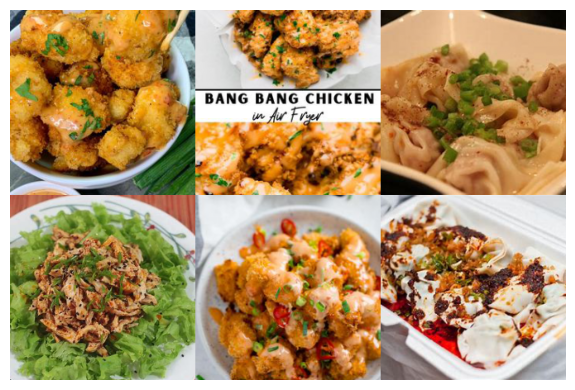

In [130]:
import matplotlib.pyplot as plt

food_dataloader.set_mode('train', True) 

imgs = []
count = 0
for i, (image, features, class_id) in enumerate((food_dataloader)):
#     print(class_id) # We expect the first class id to be random when shuffle is true
                  # Here is where we would run whatever training iteration we wanted.
    imgs.append(image)
    count += 1
    if count >= 6:
        break
        
example_images = np.concatenate([np.concatenate(imgs[:3], axis=1), np.concatenate(imgs[3:], axis=1)], axis=0)
fig, ax = plt.subplots(figsize=(8, 4))
ax.imshow(example_images)
ax.axis('off')
plt.tight_layout()

In [131]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
import pickle
import numpy as np

def save_model(classifier):
    filename = '/Users/cap/Dropbox/Cuisines/Models/NutriCaptureML_' + classifier.algorithm
    pickle.dump(classifier, open(filename, 'wb'))

def gather_features_foods(all_classes, mode, shuffle):
    #Load preprocessed features from dataloader
    food_dataloader.set_mode(mode, shuffle)
    image_features = []
    classes = []
    for j, (image, features, class_id) in enumerate(food_dataloader):
        if class_id not in all_classes:
            continue
        classes.append(list(all_classes).index(class_id))
        image_features.append(features)
    scaler = StandardScaler()
    classes = np.array(classes)
    image_features = np.stack(image_features, axis=0)
    return image_features, classes

def train(classifier, all_classes=None, quiet=False, return_lda=False):
    if not quiet:
        print("TRAINING FOODS")
    train_features, train_classes = gather_features_foods(all_classes, 'train', True)
    # train LDA and train classifier
    lda = LinearDiscriminantAnalysis(n_components=1).fit(train_features, train_classes)
    train_features = lda.transform(train_features)
    classifier.fit(train_features, train_classes)
    
#     save_model(classifier)
    
    # score train classification
    train_acc = classifier.score(train_features, train_classes)
    
    #load validation data
    val_features, val_classes = gather_features_foods(all_classes, 'val', False)
    
    # transform LDA
    val_features = lda.transform(val_features)
    # score validation classification
    val_acc = classifier.score(val_features, val_classes)
    
    if return_lda:
        return train_acc, val_acc, lda
    return train_acc, val_acc

In [132]:
all_classes = np.random.choice(range(1,6), 2, replace=False)
features = 5
depth = 18
estimators = 15
classifier = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=depth),
    n_estimators=estimators,
    learning_rate=1.5,
    algorithm="SAMME"
)

model_filename = 'NutriCaptureML'
pickle.dump

new_classes = np.array([food_dict[all_classes[0]],food_dict[all_classes[1]]], "str", ndmin=1)
t_acc, v_acc = train(classifier, new_classes)


print("train_acc {} val acc {}, random {}".format(t_acc, v_acc, 1./5))

TRAINING FOODS
train_acc 1.0 val acc 0.68, random 0.2


In [133]:
from sklearn.linear_model import LogisticRegression
all_classes = np.random.choice(range(1, 6), 2, replace=False)
classifier = LogisticRegression(
                C=1000. / len(food_dataloader), penalty='l2', solver='saga', tol=0.01
             )
new_classes = np.array([food_dict[all_classes[0]],food_dict[all_classes[1]]], "str", ndmin=1)
t_acc, v_acc = train(classifier, new_classes)
print("train_acc {} val acc {}, random {}".format(t_acc, v_acc, 1./5))

TRAINING FOODS
train_acc 0.8214285714285714 val acc 0.6818181818181818, random 0.2


In [134]:
from sklearn.neural_network import MLPClassifier
classifier = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(15, 15), random_state=1, max_iter=10000, warm_start=True)
new_classes = np.array([food_dict[all_classes[0]],food_dict[all_classes[1]]], "str", ndmin=1)
t_acc, v_acc = train(classifier, new_classes)
print("train_acc {} val acc {}, random {}".format(t_acc, v_acc, 1./5))

TRAINING FOODS
train_acc 0.9642857142857143 val acc 0.7272727272727273, random 0.2


In [135]:
ada_classifiers = []
t_accs, v_accs = [], []
random_acc = [1./N for N in range(2, 6)]
for c in range(2, 6):
    added = False
    best = ()
    best_v = 0
    for depth in range(2, 18, 2):
        for estimators in range(3, 15, 3):
            if c == 5:
                all_classes = np.array(range(1, 6))
            else:
                all_classes = np.random.choice(range(1, 6), c, replace=False)
            classifier = AdaBoostClassifier(
                DecisionTreeClassifier(max_depth=depth),
                n_estimators=estimators,
                learning_rate=1.5,
                algorithm="SAMME"
            )
            new_classes = np.array([food_dict[all_classes[0]],food_dict[all_classes[1]]], "str", ndmin=1)
            t_acc, v_acc, lda = train(classifier, new_classes, True, True)
            if v_acc > best_v:
                best = (t_acc, v_acc)
                if added:
                    ada_classifiers[-1] = (classifier, lda)
                else:
                    ada_classifiers.append((classifier, lda))
                    added = True
    t_accs.append(best[0])
    v_accs.append(best[1])
    print("{}: train acc {} val acc {} random {}".format(c, best[0], best[1], 1./c))


2: train acc 1.0 val acc 0.68 random 0.5
3: train acc 1.0 val acc 0.8421052631578947 random 0.3333333333333333
4: train acc 1.0 val acc 0.6 random 0.25
5: train acc 1.0 val acc 0.68 random 0.2


In [136]:
import random
mlp_classifiers = []
t_accs_mlp, v_accs_mlp = [], []
random_acc = [1./N for N in range(2, 6)]
for c in range(2, 6):
    added = False
    for hidden in range(5, 20, 5):
        best = ()
        best_v = 0
        if c == 5:
            all_classes = np.array(range(1, 6))
        else:
            all_classes = np.random.choice(range(1, 6), c, replace=False)
        features = 5
        depth = 18
        estimators = 15
        classifier =  MLPClassifier(solver='lbfgs', alpha=1e-5,
                hidden_layer_sizes=(hidden, hidden), random_state=1,
                max_iter=10000, warm_start=True, early_stopping=True
        )
        new_classes = np.array([food_dict[all_classes[0]],food_dict[all_classes[1]]], "str", ndmin=1)
        t_acc, v_acc, lda = train(classifier, new_classes, True, True)
        if v_acc > best_v:
            best = (t_acc, v_acc)
            if added:
                mlp_classifiers[-1] = (classifier, lda)
            else:
                mlp_classifiers.append((classifier, lda))
    t_accs_mlp.append(best[0])
    v_accs_mlp.append(best[1])
    print("{}: train acc {} val acc {} random {}".format(c, best[0], best[1], 1./c))

2: train acc 0.9833333333333333 val acc 0.8125 random 0.5
3: train acc 0.9411764705882353 val acc 0.5555555555555556 random 0.3333333333333333
4: train acc 0.8452380952380952 val acc 0.7272727272727273 random 0.25
5: train acc 0.82 val acc 0.6 random 0.2


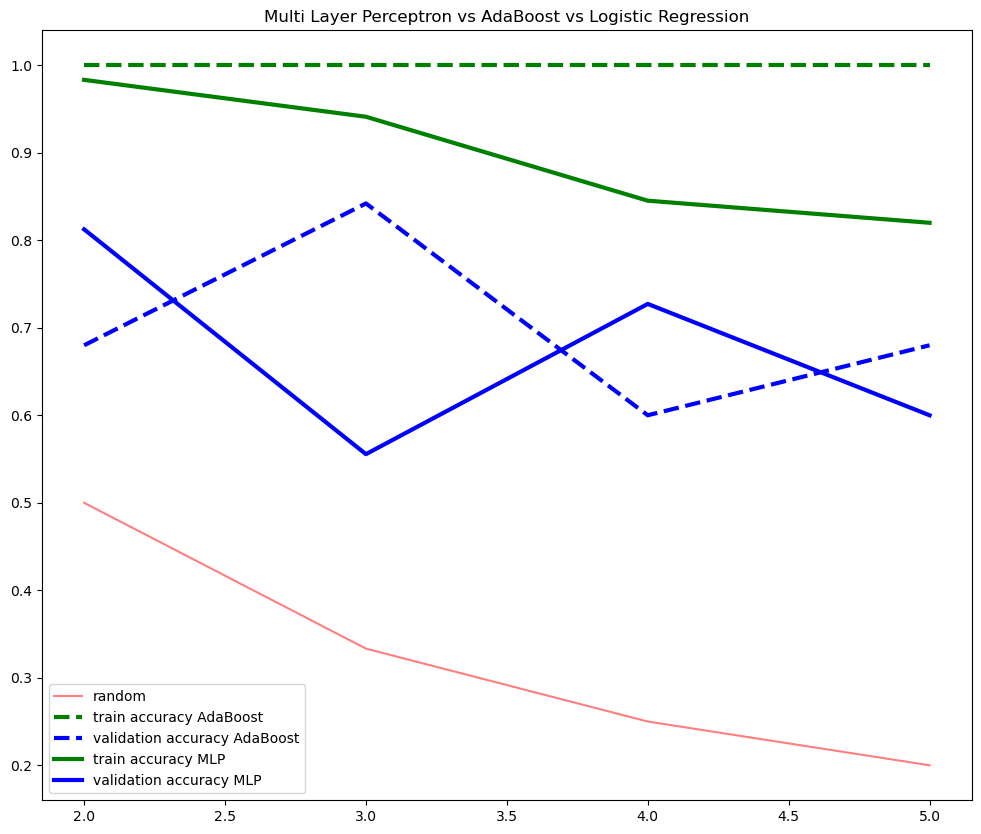

In [137]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.plot(range(2, 6), random_acc, '#FF000080', label="random")
ax.plot(range(2, 6), t_accs, '#008000FF', linestyle='--', linewidth=3.0, label="train accuracy AdaBoost")
ax.plot(range(2, 6), v_accs, '#0000FFFF', linestyle='--', linewidth=3.0, label="validation accuracy AdaBoost")
ax.plot(range(2, 6), t_accs_mlp, '#008000FF', linestyle='-',linewidth=3.0, label="train accuracy MLP")
ax.plot(range(2, 6), v_accs_mlp, '#0000FFFF', linestyle='-', linewidth=3.0, label="validation accuracy MLP")
ax.set_title('Multi Layer Perceptron vs AdaBoost vs Logistic Regression')
plt.legend()
plt.show()

In [320]:
class PredictImage:
    def __init__(self, image, classifier, img_class, width=224, height=224):
        self.feature_extractor = FeatureExtractor()
        self.classifier = classifier
        self.height = height;
        self.width = width;
        self.image = image;
        self.features = None;
        
    def transform(self, image):
        if len(image.shape) == 2:
            # Add a third dimension to grayscale images
            image = np.expand_dims(image, axis=2)
            
        height, width, ch = image.shape
        if width < height:
            new_width = self.width
            scale = self.width / width
            new_height = int(height * scale)
        else:
            new_height = self.height
            scale = self.height / height
            new_width = int(width * scale)
        image_tf = transforms.resize(image, (new_height, new_width), 2)
        # center crop
        w_start = 0
        w_stop = self.width
        h_start = 0
        h_stop = self.height
        if new_width > self.width:
            start = (new_width - self.width) // 2
            w_start = start
            w_stop = start + self.width
        if new_height > self.height:
            start = (new_height - self.height) // 2
            h_start = start
            h_stop = start + self.height
        image_tf = image_tf[h_start:h_stop, w_start:w_stop, :]
        return image_tf
    
    def prediction(self):
        fig, ax = plt.subplots(figsize=(8, 4))
        ax.imshow(self.image)
        ax.axis('off')
        ax.set_title(self)
        plt.tight_layout()
        
        image = self.transform(self.image)
        features = self.feature_extractor.extract_features(image)
        features_ada = ada_lda.transform(features.reshape(1, 20))        
        pred_classifier = int(self.classifier.predict(features_ada))
        return pred_classifier
    
    def __getitem__(self, index):
        return self.image, self.features, index

In [321]:
image_filepath = '/Users/cap/Dropbox/Cuisines/images/wontons-in-chili-oil/OIP.jpg'
img_class = 'wontons-in-chili-oil'
image = imageio.imread(image_filepath)

1


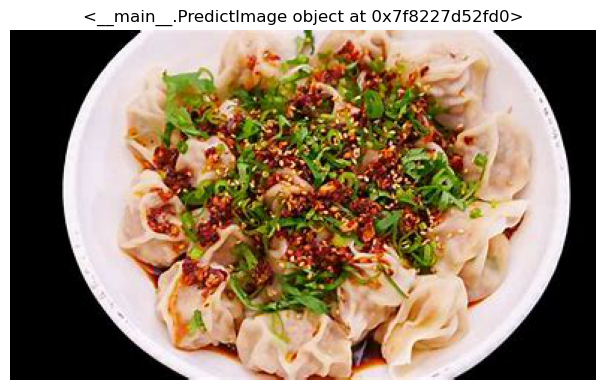

In [322]:
ada_classifier, ada_lda = ada_classifiers[0]
predictImage = PredictImage(image, ada_classifier, img_class).prediction()
print(predictImage)